### Imports

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
from pathlib import Path 

### Device agnostic code
This is used to utilize GPU if the device has one

In [2]:
# Writing device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


### Data
Create data using linear regression model.
* Formula: y = (m*x) + c

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
steps = 0.02

X = torch.arange(start, end, step= steps).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split Data

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Checking the size:
print(f"X_train datasize: {len(X_train)}\ny_train datasize: {len(y_train)}")
print(f"x_test datasize: {len(X_test)}\ny_test datasize:: {len(y_test)}")

X_train datasize: 40
y_train datasize: 40
x_test datasize: 10
y_test datasize:: 10


### Plot data

In [5]:
# Plots training data, test data, and compares predictions.
def plot_pred(train_data= X_train, train_labels= y_train, test_data= X_test, test_labels= y_test, predictions= None):    
    plt.figure(figsize=(10,7))

    # Plotting training data
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")
    
    #Plotting test data
    plt.scatter(test_data, test_labels, c='g', s=4, label= "Test Data")

    # Check if any predictions have been made:
    if predictions is not None:
        # Plot predictions
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    # Show the legend
    plt.legend(prop={"size": 14})

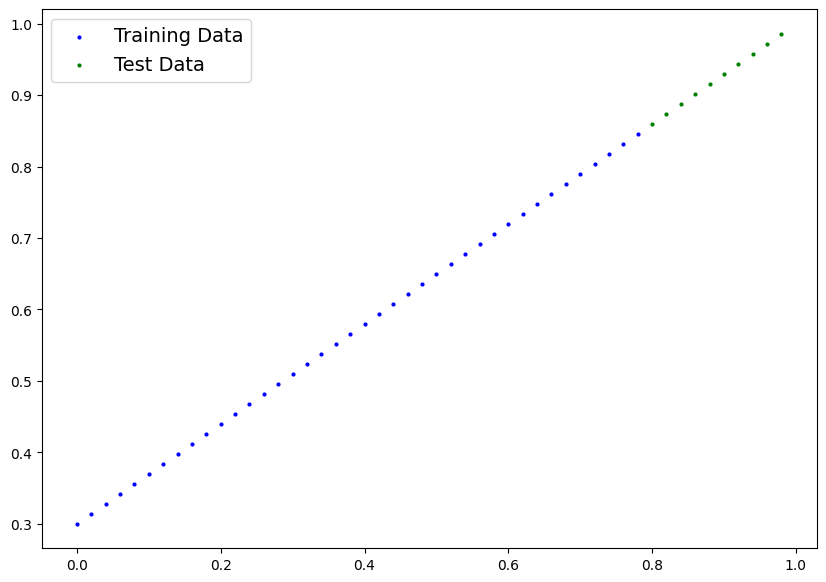

In [6]:
plot_pred(X_train, y_train, X_test, y_test)

### Build Model
Building a linear model by subclassing nn.Module 

In [7]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Using nn.Linear() to make the model
        self.linear_layer = nn.Linear(in_features =1, out_features= 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### Train Model


In [8]:
# Set the model to utilize the GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [9]:
# Setting up the loss function
loss_fn = nn.L1Loss()

# Setting up otimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr= 0.01)

In [10]:
# Setting up the loop
torch.manual_seed(42)

epochs= 200

# put data on GPU
X_train = X_train.to(device) 
X_test = X_test.to(device)
y_train= y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forrward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    #### Testing ####
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print whats happening
    if epoch % 10 == 0:
        print(f"Epoch:{epoch} | Loss:{loss} | Test Bias:{test_loss}")

Epoch:0 | Loss:0.5551779270172119 | Test Bias:0.5739762187004089
Epoch:10 | Loss:0.439968079328537 | Test Bias:0.4392664134502411
Epoch:20 | Loss:0.3247582018375397 | Test Bias:0.30455657839775085
Epoch:30 | Loss:0.20954833924770355 | Test Bias:0.16984669864177704
Epoch:40 | Loss:0.09433845430612564 | Test Bias:0.03513690456748009
Epoch:50 | Loss:0.023886388167738914 | Test Bias:0.04784907028079033
Epoch:60 | Loss:0.0199567973613739 | Test Bias:0.045803118497133255
Epoch:70 | Loss:0.016517987474799156 | Test Bias:0.037530567497015
Epoch:80 | Loss:0.01308917161077261 | Test Bias:0.02994490973651409
Epoch:90 | Loss:0.009653178043663502 | Test Bias:0.02167237363755703
Epoch:100 | Loss:0.0062156799249351025 | Test Bias:0.014086711220443249
Epoch:110 | Loss:0.002787243574857712 | Test Bias:0.005814164876937866
Epoch:120 | Loss:0.0012645035749301314 | Test Bias:0.013801801018416882
Epoch:130 | Loss:0.0012645035749301314 | Test Bias:0.013801801018416882
Epoch:140 | Loss:0.0012645035749301314 

In [11]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [12]:
weight, bias

(0.7, 0.3)

### Making Predictions

In [13]:
# Turn model into eval mode
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

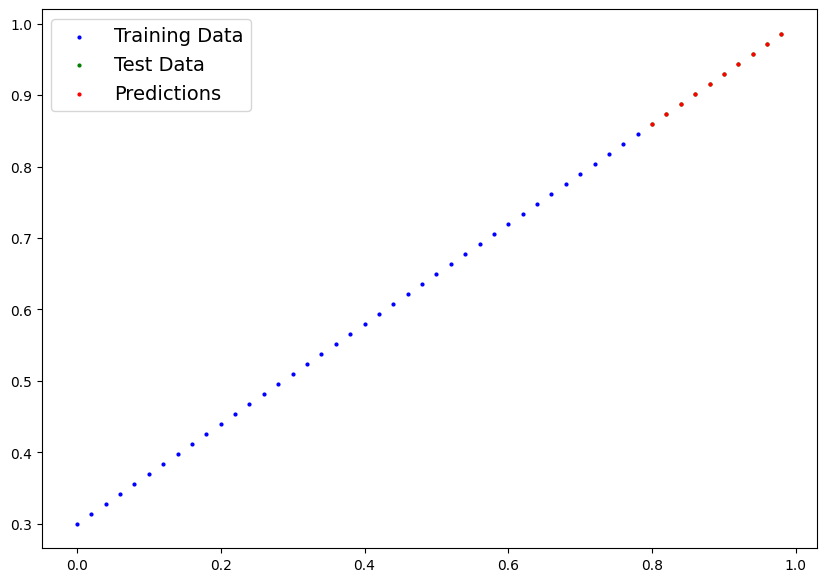

In [14]:
plot_pred(predictions= y_preds.cpu())

### Saving the model

In [15]:
# 1. Create model directory
MODEL_PATH =Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok= True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f= MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


### Loading th saved model

In [16]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [17]:
loaded_model_1.to(device)
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [18]:
# Evaluate the loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')